In [1]:
import scipy.io
import scipy.stats
import matplotlib.pyplot as plt
import re
import os
from IPython.display import Image 
import cv2
from tempfile import TemporaryFile
from scipy import stats
from torchvision import transforms
import pandas as pd
import shutil
import datetime
import glob
from scipy import integrate
from sklearn.decomposition import PCA
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from PIL import ImageFile, Image
import sys
sys.path.insert(1, '../architecture')
sys.path.insert(2, '../dataLoaders')
from ProUNet import *
import torchvision.models as models
from MapillaryDataLoader import *
# from VolvoDataLoader import *
from volvoDataLoader_onFly import *
from tqdm import tqdm
from torchsummary import summary
from matplotlib.patches import Rectangle
import torch.nn.functional as F
import numpy as np
from sklearn.manifold import TSNE

import numpy as np
import cv2 as cv
#from MapRSCD import *
%matplotlib inline

2023-11-07 12:55:11.704900: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
transform_in = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4191, 0.4586, 0.4700], [0.2553, 0.2675, 0.2945]),
    transforms.Resize((256,256))
])

transform_ou = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256))
])

In [3]:
args = {
    "mode":"train",
    "input_img_dim":(256,256),
    "mapillaryRootPath":'../../../datasets/augmented_mapillary',
    "cityscapesRootPath":'../../../datasets/augmented_cityscapes',
    "RSCDRootPath":'../../../datasets/RSCD',
    "volvoRootPath":"../../../datasets/VolvoAnnotatedImages/rawDataset/images",
    "reducedCategories":True
}

dataloader = volvo_onFly(**args)

In [4]:
device = torch.device('cuda:1')
model = ProUNet(gecoConfig = {"enable":False}, device = device, num_classes = dataloader.get_num_classes(), LatentVarSize = 6, beta = 3, training = True, num_samples = 16).to(device)
# check = torch.load("../checkpoints/HVAEFri_Segfri2/best.pth", map_location=device)
check = torch.load("../checkpoints/HVAEFri_volvo_onTheFly/best.pth", map_location=device)
model.load_state_dict(check['model_state_dict'])

<All keys matched successfully>

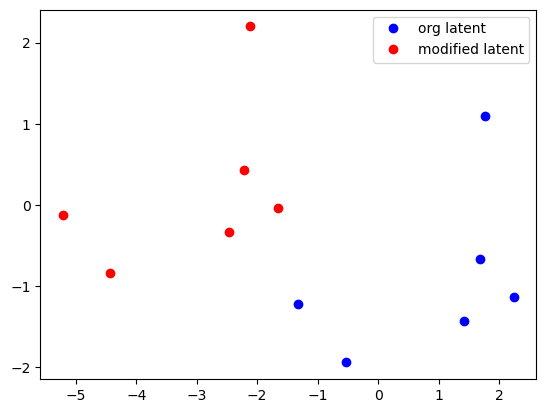

In [8]:
latent_modif = 3

for imgIdx in [550]:
    
    frame = dataloader[imgIdx]["image"].to(device)
    segs, dists, _ = model.inference(frame.unsqueeze(0))
    pca = PCA(n_components=2)
    for i in range(1000):
        flattenFeatures = torch.flatten(dists["dist1"].sample(), start_dim = 2, end_dim = 3).squeeze(0).cpu()
        pca.fit(flattenFeatures)
#     tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50)
    
    X_embedded = []
    for i in range(1):
        sample = dists["dist1"].sample()
        flattenFeatures = torch.flatten(sample, start_dim = 2, end_dim = 3).squeeze(0).cpu()
        tmp = pca.transform(flattenFeatures)
        X_embedded.extend(tmp)
    X_embedded = np.array(X_embedded)
    plt.plot(X_embedded[:,0], X_embedded[:,1], "bo", label = "org latent")
    X_embedded_modified = pca.transform(flattenFeatures+latent_modif)
    plt.plot(X_embedded_modified[:,0], X_embedded_modified[:,1], "ro", label = "modified latent")
plt.legend()
plt.show()

/home/lunet/wsmo6/.conda/envs/3.8/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


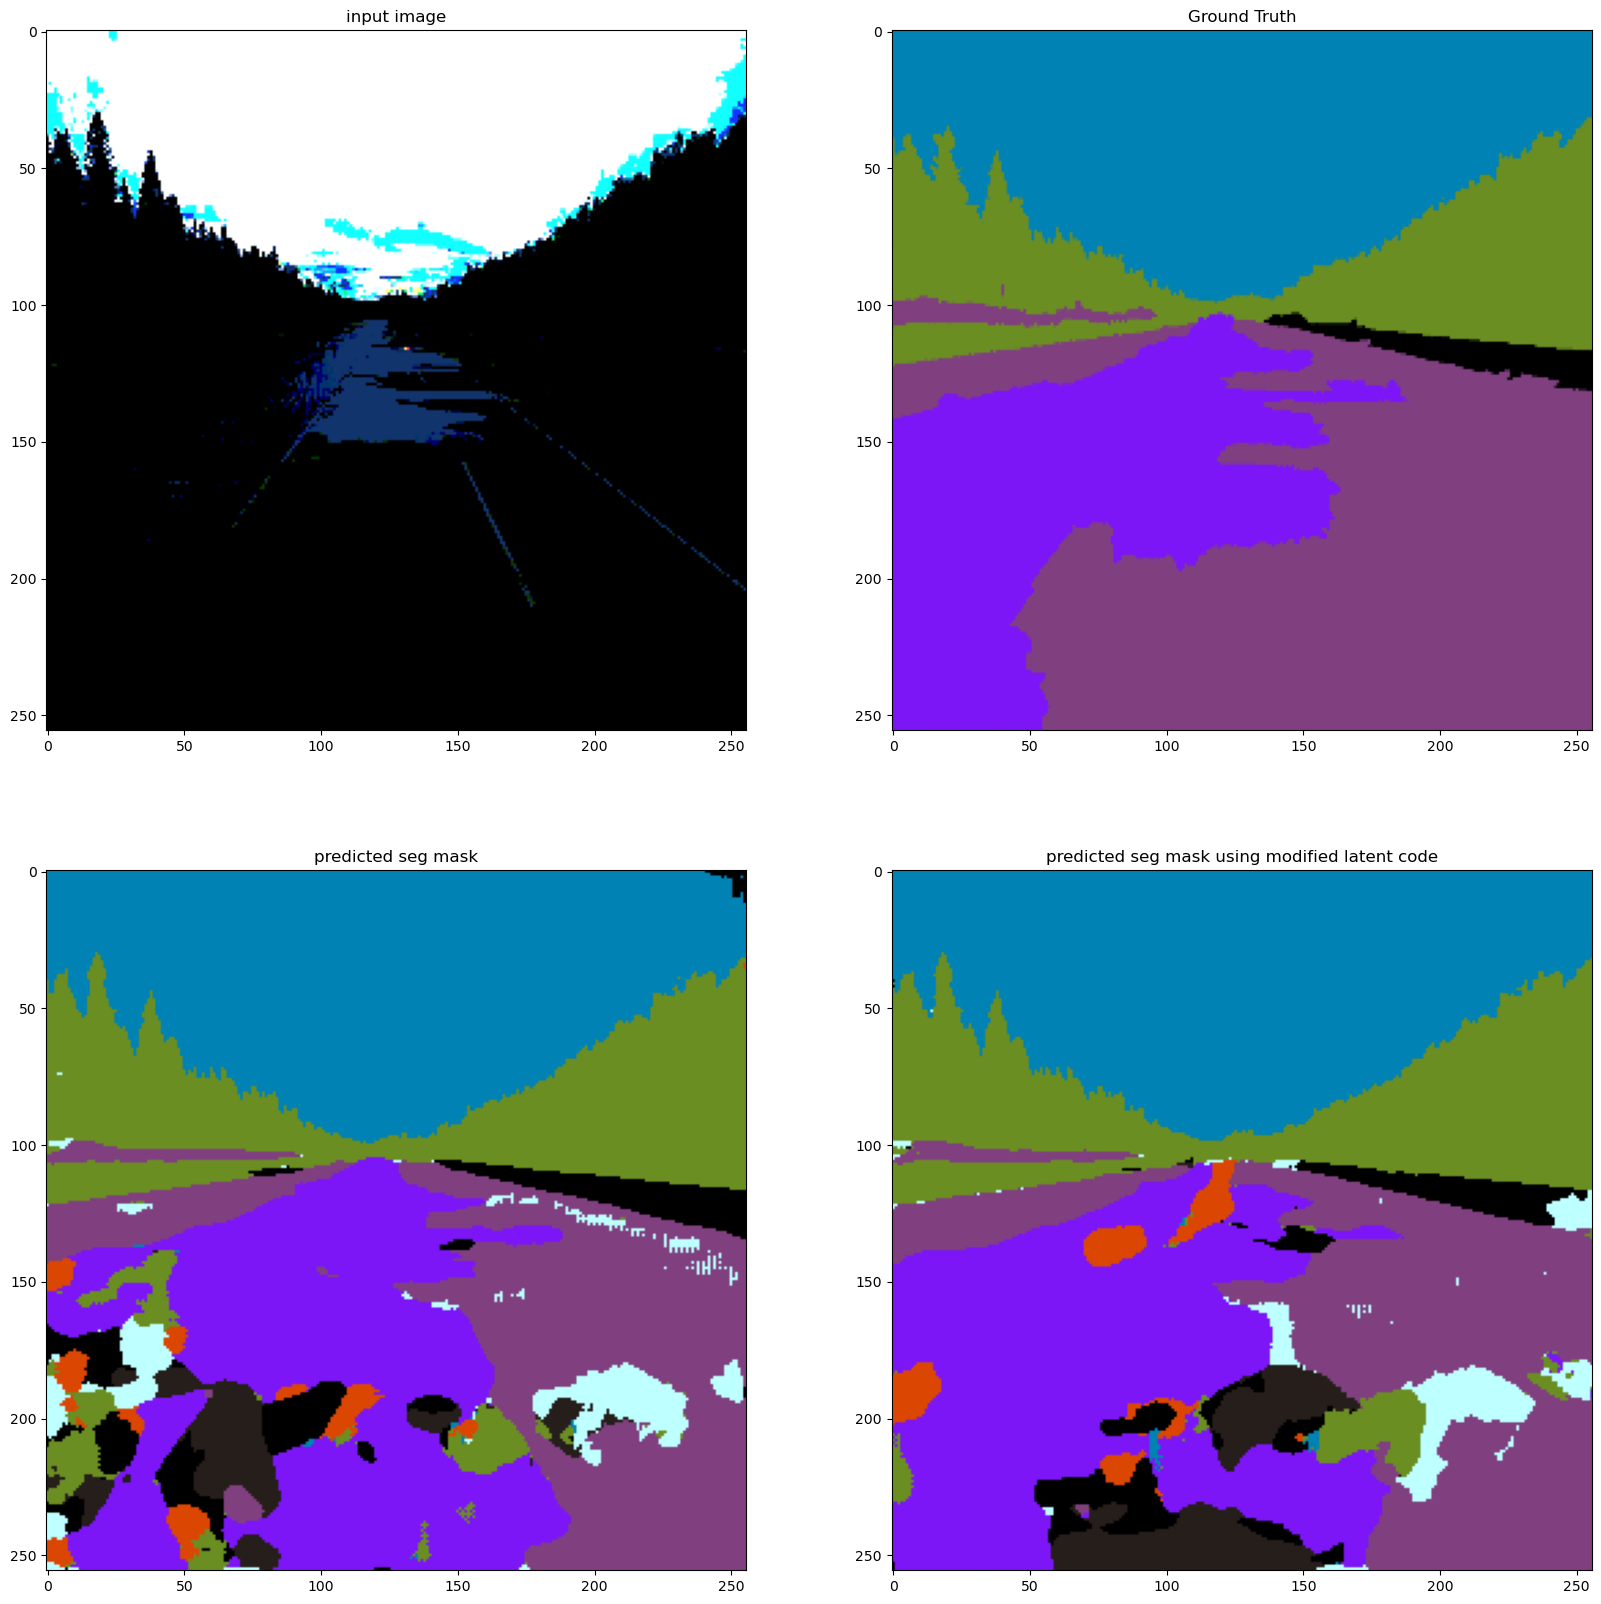

In [9]:
imgIdx = 550
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(20,20))

ax[0][0].imshow(dataloader[imgIdx]["image"].permute(1, 2, 0))
ax[0][0].set_title("input image")

ax[0][1].imshow(dataloader[imgIdx]["seg"].permute(1, 2, 0))
ax[0][1].set_title("Ground Truth")


segs, _ = model.latentVisualize(dataloader[imgIdx]["image"].unsqueeze(0).to(device), sampleLatent1 = sample, sampleLatent2 = None, sampleLatent3 = None)
ax[1][0].set_title("predicted seg mask")
ax[1][0].imshow(dataloader.prMask_to_color(segs.cpu()).squeeze(0).permute(1, 2, 0))


segs, _ = model.latentVisualize(dataloader[imgIdx]["image"].unsqueeze(0).to(device), sampleLatent1 = sample+latent_modif, sampleLatent2 = None, sampleLatent3 = None)
ax[1][1].set_title("predicted seg mask using modified latent code")
ax[1][1].imshow(dataloader.prMask_to_color(segs.cpu()).squeeze(0).permute(1, 2, 0))

plt.show()